In [1]:
#Required python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import re
import torch
import nltk
import nltk.data
from string import punctuation 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords

In [2]:
df_senti=pd.read_csv("../data/raw/sentiments_training.csv", encoding= 'unicode_escape')
df_test=pd.read_csv("../data/raw/sentiments_test.csv", encoding= 'unicode_escape')

In [3]:
df_senti.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [5]:
df_senti.shape,df_test.shape

((27481, 10), (4815, 9))

In [6]:
print("Training set:",df_senti['sentiment'].value_counts())
print("Test set:",df_test['sentiment'].value_counts())

Training set: neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
Test set: neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64


In [7]:
df_senti['cleaned_text'] = df_senti['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)


In [8]:
df_senti['cleaned_text'][5]

' - some shameless plugging for the best Rangers forum on earth'

In [9]:
print(df_senti['sentiment'].value_counts())

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


In [11]:
df=df_senti[['cleaned_text','sentiment']]

In [12]:
df=df.reset_index()
df

,index,cleaned_text,sentiment
0,0,"I`d have responded, if I were going",neutral
1,1,Sooo SAD I will miss you here in San Diego!!!,negative
2,2,my boss is bullying me...,negative
3,3,what interview! leave me alone,negative
4,4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...,...
27476,27476,wish we could come see u on Denver husband l...,negative
27477,27477,I`ve wondered about rake to. The client has ...,negative
27478,27478,Yay good for both of you. Enjoy the break - y...,positive
27479,27479,But it was worth it ****.,positive


In [13]:
df.to_csv("../data/processed/cleaned_text_forbert_sentiment.csv", index=False, header=False)

In [14]:
df['labels'] = df['sentiment'].factorize()[0]
df.head()

,index,cleaned_text,sentiment,labels
0,0,"I`d have responded, if I were going",neutral,0
1,1,Sooo SAD I will miss you here in San Diego!!!,negative,1
2,2,my boss is bullying me...,negative,1
3,3,what interview! leave me alone,negative,1
4,4,"Sons of ****, why couldn`t they put them on t...",negative,1


In [15]:
uniquevalues = pd.unique(df[['sentiment']].values.ravel())
df_unique=pd.DataFrame(uniquevalues,columns=['sentiment'])
df_unique

,sentiment
0,neutral
1,negative
2,positive


In [31]:
df['cleaned_text'] = df['cleaned_text'].astype(str)

In [16]:
df_test=df_test.dropna()
df_test

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0
...,...,...,...,...,...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,noon,21-30,Nicaragua,6624554.0,120340.0,55.0
3530,416863ce47,All alone in this old house again. Thanks for...,positive,night,31-45,Niger,24206644.0,1266700.0,19.0
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,morning,46-60,Nigeria,206139589.0,910770.0,226.0
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,noon,60-70,North Korea,25778816.0,120410.0,214.0


In [18]:
df_test['cleaned_text'] = df_test['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)


In [19]:
df_test=df_test.reset_index()
df_test=df_test[['cleaned_text','sentiment']].copy()

In [20]:
mapp={'neutral':0,'negative':1,'positive':2}
df_test['labels']=df_test['sentiment'].map(mapp)

In [21]:
df_test

,cleaned_text,sentiment,labels
0,Last session of the day,neutral,0
1,Shanghai is also really exciting (precisely -...,positive,2
2,"Recession hit Veronique Branquinho, she has to...",negative,1
3,happy bday!,positive,2
4,- I like it!!,positive,2
...,...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",negative,1
3530,All alone in this old house again. Thanks for...,positive,2
3531,I know what you mean. My little dog is sinkin...,negative,1
3532,_sutra what is your next youtube video gonna b...,positive,2


In [22]:
#importing libraries for models and nlp tasks
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sentence_transformers import SentenceTransformer


In [23]:
ytrain =df['labels']
ytest=df_test['labels']

In [32]:
Xtrain=df['cleaned_text']
Xtest=df_test['cleaned_text']

In [25]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [26]:
def sentence(text):
    return model.encode(text)
    

In [27]:
def bertembeddings(Xtrain,Xtest):
    Xtrain=Xtrain
    Xtest=Xtest
    
    with torch.no_grad():    


        train = Xtrain.apply(lambda x: sentence(x))
        test = Xtest.apply(lambda x: sentence(x))


    tf= [x for x in train.transpose()]
    train_features = np.asarray(tf)

    t= [x for x in test.transpose()]
    test_features = np.asarray(t)
    
    return train_features,test_features

In [33]:
train_embed,test_embed=bertembeddings(Xtrain,Xtest)

##### Logistic Regression model

In [34]:
#Logistic Regression with multinomial
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_mn.fit(train_embed, ytrain)

/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [35]:
ypred_lr_mn=lr_mn.predict(test_embed)

In [36]:
tr_acc_lr_mn = lr_mn.score(train_embed, ytrain)*100
test_acc_lr_mn =  accuracy_score(ytest,ypred_lr_mn) * 100
print(tr_acc_lr_mn,test_acc_lr_mn)

70.32131290709945 70.62818336162988


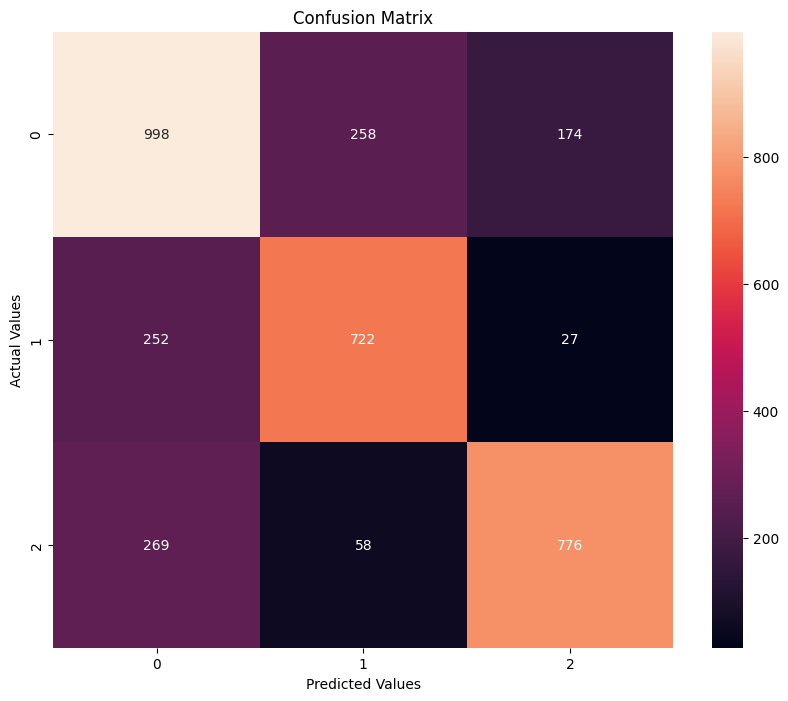

In [37]:
cm = confusion_matrix(ytest, ypred_lr_mn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [38]:
pickle.dump(lr_mn, open('../models/lr_mn_sentiment_bert.pkl', 'wb'))

##### SVM Classifier

In [39]:
%%time
svm = SVC( kernel ='linear',C = 1, decision_function_shape='ovo')
svm.fit(train_embed, ytrain)

CPU times: user 2min 48s, sys: 1.28 s, total: 2min 49s
Wall time: 2min 49s


SVC(C=1, decision_function_shape='ovo', kernel='linear')

In [40]:
ypred_svm=svm.predict(test_embed)

In [41]:
tr_acc_svm= svm.score(train_embed, ytrain)*100
test_acc_svm =  accuracy_score(ytest,ypred_svm) * 100
print(tr_acc_svm,test_acc_svm)

70.17575779629563 70.37351443123939


In [42]:
pickle.dump(svm, open('../models/svm_sentiment_bert.pkl', 'wb'))

##### KNN classifier

In [45]:
%%time
k_range = range(10,200,10)
train_scores = []
test_scores = []
for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    knn=neigh.fit(train_embed,ytrain)
    tr_acc_knn = knn.score(train_embed, ytrain)*100
    ypred_knn = knn.predict(test_embed)
    accuracy_knn = accuracy_score(ytest,ypred_knn)
    test_acc_knn = accuracy_knn * 100
    train_scores.append(tr_acc_knn)
    test_scores.append(test_acc_knn)

CPU times: user 8min 15s, sys: 19.2 s, total: 8min 34s
Wall time: 1min 12s


In [46]:
K=pd.Series(k_range)


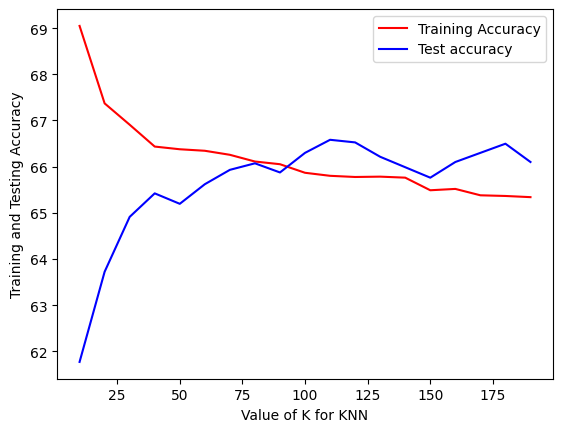

In [47]:
plt.plot(K, train_scores,color='r',label='Training Accuracy')
plt.plot(K, test_scores,color='b',label='Test accuracy')


plt.xlabel('Value of K for KNN')
plt.ylabel('Training and Testing Accuracy')
plt.legend()
plt.show()

for small range of k values

In [48]:
%%time
k_range = range(70,90)
train_scores = []
test_scores = []
for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    knn=neigh.fit(train_embed,ytrain)
    tr_acc_knn = knn.score(train_embed, ytrain)*100
    ypred_knn = knn.predict(test_embed)
    accuracy_knn = accuracy_score(ytest,ypred_knn)
    test_acc_knn = accuracy_knn * 100
    train_scores.append(tr_acc_knn)
    test_scores.append(test_acc_knn)

CPU times: user 8min 25s, sys: 15.2 s, total: 8min 40s
Wall time: 1min 15s


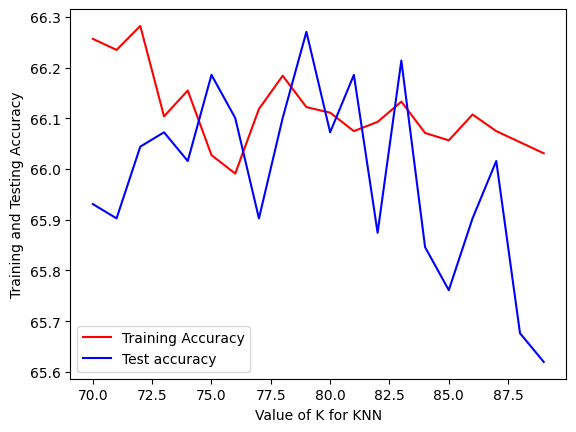

In [49]:
K=pd.Series(k_range)
plt.plot(K, train_scores,color='r',label='Training Accuracy')
plt.plot(K, test_scores,color='b',label='Test accuracy')
plt.xlabel('Value of K for KNN')
plt.ylabel('Training and Testing Accuracy')
plt.legend()
plt.show()

In [50]:
neigh = KNeighborsClassifier(n_neighbors=73)
knn=neigh.fit(train_embed,ytrain)
tr_acc_knn = knn.score(train_embed, ytrain)*100
ypred_knn = knn.predict(test_embed)
accuracy_knn = accuracy_score(ytest,ypred_knn)
test_acc_knn = accuracy_knn * 100

print(tr_acc_knn,test_acc_knn)

66.10385357155853 66.07243916242219


In [51]:
pickle.dump(knn, open('../models/knn_sentiment_bert.pkl', 'wb'))

##### XGB Classifier

In [57]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 3,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)

In [58]:
eval_set = [(train_embed, ytrain),(test_embed, ytest)]

In [59]:
xgb.fit(train_embed, ytrain, eval_metric='auc', eval_set=eval_set, verbose=True)


[0]	validation_0-auc:0.73180	validation_1-auc:0.70344
[1]	validation_0-auc:0.76089	validation_1-auc:0.72750
[2]	validation_0-auc:0.77648	validation_1-auc:0.74130
[3]	validation_0-auc:0.78872	validation_1-auc:0.75027
[4]	validation_0-auc:0.79494	validation_1-auc:0.75613
[5]	validation_0-auc:0.80004	validation_1-auc:0.75758
[6]	validation_0-auc:0.80607	validation_1-auc:0.76142
[7]	validation_0-auc:0.81010	validation_1-auc:0.76360
[8]	validation_0-auc:0.81471	validation_1-auc:0.76647
[9]	validation_0-auc:0.81815	validation_1-auc:0.76967
[10]	validation_0-auc:0.82217	validation_1-auc:0.77205
[11]	validation_0-auc:0.82546	validation_1-auc:0.77668
[12]	validation_0-auc:0.82884	validation_1-auc:0.77825
[13]	validation_0-auc:0.83178	validation_1-auc:0.77975
[14]	validation_0-auc:0.83520	validation_1-auc:0.78227
[15]	validation_0-auc:0.83808	validation_1-auc:0.78424
[16]	validation_0-auc:0.84070	validation_1-auc:0.78588
[17]	validation_0-auc:0.84333	validation_1-auc:0.78745
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [60]:
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

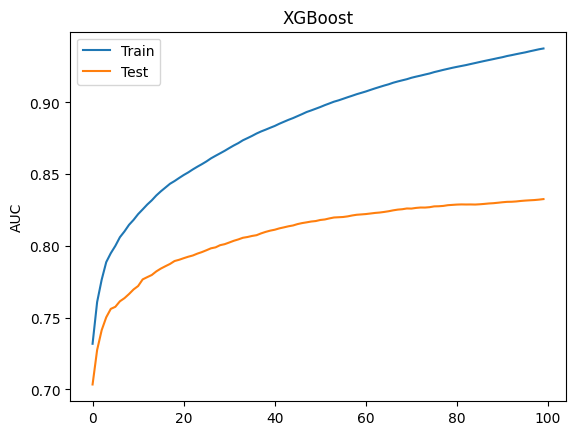

In [61]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost')
plt.show()

In [67]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=20, max_depth=5,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 3,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)



In [68]:
%%time
xgb.fit(train_embed, ytrain)

CPU times: user 1min, sys: 1.68 s, total: 1min 1s
Wall time: 8.01 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_class=3, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [69]:
ypred_xgb=xgb.predict(test_embed)

In [70]:
tr_acc_xgb = xgb.score(train_embed, ytrain)*100
test_acc_xgb =  accuracy_score(ytest,ypred_xgb) * 100
print(tr_acc_xgb,test_acc_xgb)

67.1372948582657 61.148839841539335


In [71]:
pickle.dump(xgb, open('../models/xgb_basic_sentiment_bert.pkl', 'wb'))